In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import minimize, Bounds, LinearConstraint

In [2]:
df = pd.read_csv('/Users/dominicprenovost/Programmation/Markowitz/5_Industry_Portfolios.CSV', header=6)

df_5 = df.iloc[1109:1169]

df_5 = df_5.rename(columns={'Unnamed: 0': 'Date'})

df_5['Date'] = pd.to_datetime(df_5['Date'], format='%Y%m')

df_5.set_index('Date', inplace=True)

df_5 =df_5.apply(pd.to_numeric, errors='coerce')

# Number of bootstrap samples you want to generate
num_bootstrap_samples = 100

# Perform bootstrap sampling
bootstrap_samples = [df_5.sample(n=len(df_5), replace=True) for _ in range(num_bootstrap_samples)]

# Rendement espéré du portefeuille cible
R_cible = 0.10

# Initialize lists to store efficient frontier data
all_volatilities = []
all_returns = []

for bootstrap_df in bootstrap_samples:
    bootstrap_df = bootstrap_df.values / 100
    sigma_boot = np.cov(bootstrap_df, rowvar=False)
    z_barre = np.mean(bootstrap_df, axis=0)
    Z_barre = z_barre
    ones = np.ones(len(Z_barre))  # Vecteur de uns

    # Your optimization code goes here...
       # Inversion de la matrice de covariance
    Sigma_inv = np.linalg.inv(sigma_boot)

    # Construction de la matrice A et du vecteur b
    A = np.array([
        [np.dot(ones, np.dot(Sigma_inv, ones)), np.dot(ones, np.dot(Sigma_inv, Z_barre))],
        [np.dot(Z_barre, np.dot(Sigma_inv, ones)), np.dot(Z_barre, np.dot(Sigma_inv, Z_barre))]
    ])
    b = np.array([1, R_cible])

    # Inversion de la matrice A
    A_inv = np.linalg.inv(A)
    
    # Résolution pour obtenir les multiplicateurs de Lagrange
    lambda_theta = np.dot(A_inv, b)

    # Calcul des poids optimaux du portefeuille
    w_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)

    # Calculations for efficient frontier

    # Étendre l'intervalle des rendements cibles pour la frontière complète
    rendements_cibles_etendus = np.linspace(min(Z_barre) - 0.015, max(Z_barre) + 0.015, 200)

    # Calcul des volatilités et des rendements pour la frontière complète
    volatilites_optimales_etendues = []
    rendements_optimaux_etendus = []
    for R_cible in rendements_cibles_etendus:
        b = np.array([1, R_cible])
        lambda_theta = np.dot(A_inv, b)
        wi_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)
        rendement_optimal = np.dot(wi_optimal, Z_barre)
        volatilite_optimale = np.sqrt(np.dot(wi_optimal.T, np.dot(sigma_boot, wi_optimal)))
        rendements_optimaux_etendus.append(rendement_optimal)
        volatilites_optimales_etendues.append(volatilite_optimale)


    # Store data for efficient frontier
    all_volatilities.append(volatilites_optimales_etendues)
    all_returns.append(rendements_optimaux_etendus)
    
    # Risk-free rate (you need to define your risk-free rate)
    rf = 0.0044

    # Calculate the slope of the CML
    CML_slope = (max(rendements_optimaux_etendus) - rf) / max(volatilites_optimales_etendues)

    # Generate standard deviations for the CML
    CML_std = np.linspace(0, max(volatilites_optimales_etendues), 100)

    # Calculate corresponding expected returns for the CML
    CML_ret = rf + CML_slope * CML_std

    # Calculate Sharpe Ratios for all points on the efficient frontier
    sharpe_ratios = [(r - rf) / v for r, v in zip(rendements_optimaux_etendus, volatilites_optimales_etendues)]

    # Find the index of the portfolio with the maximum Sharpe ratio
    max_sharpe_index = np.argmax(sharpe_ratios)

    # Extract the return and volatility of the tangent portfolio
    tangent_portfolio_return = rendements_optimaux_etendus[max_sharpe_index]
    tangent_portfolio_volatility = volatilites_optimales_etendues[max_sharpe_index]


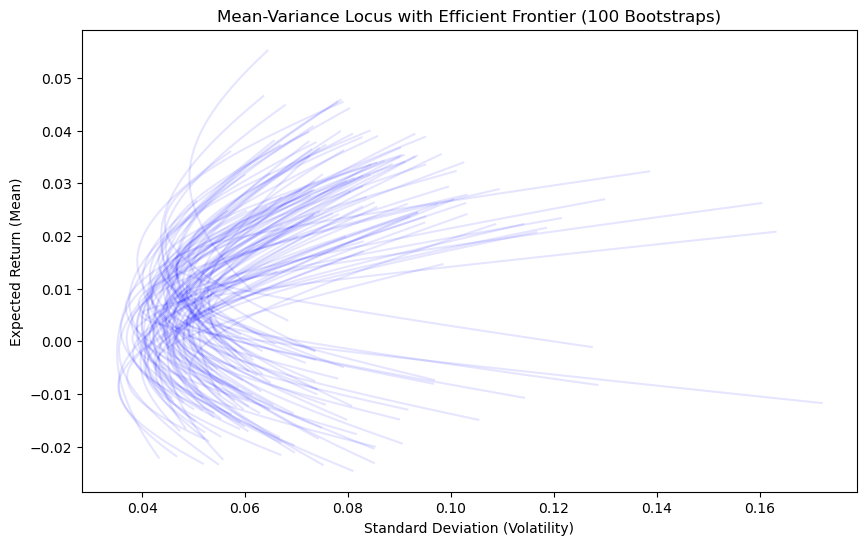

In [3]:
# Plotting
plt.figure(figsize=(10, 6))
for volatilities, returns in zip(all_volatilities, all_returns):
    plt.plot(volatilities, returns, color='blue', alpha=0.1)  # Alpha for transparency
# Add labels and legend
plt.title('Mean-Variance Locus with Efficient Frontier (100 Bootstraps)')
plt.xlabel('Standard Deviation (Volatility)')
plt.ylabel('Expected Return (Mean)')
#plt.grid(True)
plt.show()

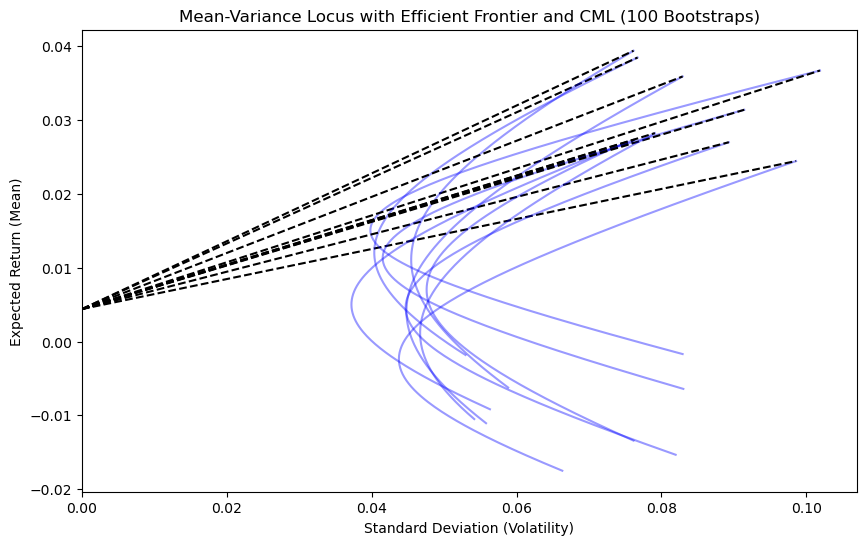

In [13]:
# Plotting
plt.figure(figsize=(10, 6))
for volatilities, returns in zip(all_volatilities, all_returns):
    plt.plot(volatilities, returns, color='blue', alpha=0.4)  # Alpha for transparency

    # Calculate the slope of the CML
    CML_slope = (max(returns) - rf) / max(volatilities)

    # Generate standard deviations for the CML
    CML_std = np.linspace(0, max(volatilities), 100)

    # Calculate corresponding expected returns for the CML
    CML_ret = rf + CML_slope * CML_std

    # Calculate Sharpe Ratios for all points on the efficient frontier
    sharpe_ratios = [(r - rf) / v for r, v in zip(returns, volatilities)]

    # Find the index of the portfolio with the maximum Sharpe ratio
    max_sharpe_index = np.argmax(sharpe_ratios)

    # Extract the return and volatility of the tangent portfolio
    tangent_portfolio_return = returns[max_sharpe_index]
    tangent_portfolio_volatility = volatilities[max_sharpe_index]

    # Plot Capital Market Line and Tangent Portfolio
    plt.plot(CML_std, CML_ret, label='Capital Market Line', color='black', linestyle='--')
    #plt.scatter(tangent_portfolio_volatility, tangent_portfolio_return, color='blue', marker='o', s=100, label='Tangent Portfolio')

# Add labels and legend
plt.title('Mean-Variance Locus with Efficient Frontier and CML (100 Bootstraps)')
plt.xlabel('Standard Deviation (Volatility)')
plt.ylabel('Expected Return (Mean)')
plt.xlim(0)
plt.show()


In [14]:
# Initialize lists to store weights, means, and variances of tangent portfolios
all_tangent_portfolio_weights = []
all_tangent_portfolio_means = []
all_tangent_portfolio_variances = []

# Loop for efficient frontier calculation
for volatilities, returns in zip(all_volatilities, all_returns):
    # Calculate the Sharpe Ratios for all points on the efficient frontier
    sharpe_ratios = [(r - rf) / v for r, v in zip(returns, volatilities)]

    # Find the index of the portfolio with the maximum Sharpe ratio
    max_sharpe_index = np.argmax(sharpe_ratios)

    # Extract the return and volatility of the tangent portfolio
    tangent_portfolio_return = returns[max_sharpe_index]
    tangent_portfolio_volatility = volatilities[max_sharpe_index]

    # Calculate the weights of the tangent portfolio

    # Inversion de la matrice de covariance
    Sigma_inv = np.linalg.inv(sigma_boot)

    # Construction de la matrice A et du vecteur b
    A = np.array([
        [np.dot(ones, np.dot(Sigma_inv, ones)), np.dot(ones, np.dot(Sigma_inv, Z_barre))],
        [np.dot(Z_barre, np.dot(Sigma_inv, ones)), np.dot(Z_barre, np.dot(Sigma_inv, Z_barre))]
    ])
    b = np.array([1, tangent_portfolio_return])

    # Inversion de la matrice A
    A_inv = np.linalg.inv(A)
    
    # Résolution pour obtenir les multiplicateurs de Lagrange
    lambda_theta = np.dot(A_inv, b)

    # Calcul des poids optimaux du portefeuille
    tangent_portfolio_weights = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)

    # Calculate the mean of the tangent portfolio
    tangent_portfolio_mean = np.dot(tangent_portfolio_weights, Z_barre)

    # Calculate the variance of the tangent portfolio
    tangent_portfolio_variance = np.dot(tangent_portfolio_weights.T, np.dot(sigma_boot, tangent_portfolio_weights))

    # Append the values to the lists
    all_tangent_portfolio_weights.append(tangent_portfolio_weights)
    all_tangent_portfolio_means.append(tangent_portfolio_mean)
    all_tangent_portfolio_variances.append(tangent_portfolio_variance)

all_tangent_portfolio_weights, all_tangent_portfolio_means, all_tangent_portfolio_variances


([array([-1.39945487,  1.25196022,  1.76913095,  0.42889733, -1.05053364]),
  array([-1.25877866,  1.211962  ,  1.61227605,  0.45843085, -1.02389023]),
  array([-2.76962682,  1.64153885,  3.29688185,  0.14124384, -1.31003772]),
  array([-1.6484438 ,  1.32275481,  2.04675528,  0.37662467, -1.09769096]),
  array([-2.85984256,  1.66718974,  3.397473  ,  0.12230398, -1.32712416]),
  array([-1.68231542,  1.33238547,  2.08452236,  0.36951367, -1.10410609]),
  array([-1.65235207,  1.32386604,  2.05111302,  0.37580417, -1.09843117]),
  array([-2.51933513,  1.57037385,  3.01780494,  0.19379001, -1.26263366]),
  array([-1.59547685,  1.30769481,  1.98769678,  0.38774454, -1.08765927]),
  array([-1.76911143,  1.35706403,  2.18130049,  0.35129174, -1.12054484])],
 [0.024456666666666668,
  0.023016884422110553,
  0.038479999999999986,
  0.027004999999999998,
  0.03940333333333333,
  0.027351666666666677,
  0.027045000000000003,
  0.035918333333333316,
  0.02646289782244556,
  0.028239999999999987],


In [19]:
df = pd.read_csv('/Users/dominicprenovost/Programmation/Markowitz/5_Industry_Portfolios.CSV', header=6)

df_5 = df.iloc[1109:1169]

df_5 = df_5.rename(columns={'Unnamed: 0': 'Date'})

df_5['Date'] = pd.to_datetime(df_5['Date'], format='%Y%m')

df_5.set_index('Date', inplace=True)

df_5 =df_5.apply(pd.to_numeric, errors='coerce')

# Number of bootstrap samples you want to generate
num_bootstrap_samples = 100

# Initialize an empty list to store optimal weights
optimal_weights_list = []

# Perform bootstrap sampling
bootstrap_samples = [df_5.sample(n=len(df_5), replace=True) for _ in range(num_bootstrap_samples)]

# Rendement espéré du portefeuille cible
R_cible = 0.10

# Initialize lists to store efficient frontier data
all_volatilities = []
all_returns = []

for bootstrap_df in bootstrap_samples:
    bootstrap_df = bootstrap_df.values / 100
    sigma_boot = np.cov(bootstrap_df, rowvar=False)
    z_barre = np.mean(bootstrap_df, axis=0)
    Z_barre = z_barre
    ones = np.ones(len(Z_barre))  # Vecteur de uns
    
    # Fonction objectif : Variance du portefeuille
    def minportfolio_variance(W,sigma_boot):
        return W.T @ (sigma_boot @ W)

    # Poids initiaux : répartition uniforme
    W = np.ones(len(Z_barre)) * (1.0 / len(Z_barre))

    # Fonction d'optimisation
    def optimize(func, W, sigma_boot, target_return):

        # Contraintes
        opt_constraints = ({'type': 'eq', 'fun': lambda W: ones @ W.T - 1},  # La somme des poids doit être égale à 1
                        {'type': 'eq', 'fun': lambda W: W.T @ z_barre - target_return},  # Le rendement attendu doit être égal au rendement cible
                        {'type': 'ineq', 'fun': lambda W: W})  # No short selling constraint

        # Optimisation
        optimal_weights = minimize(func, W, args=( sigma_boot), method='trust-constr', constraints=opt_constraints)

        return optimal_weights.x

    # Appel de la fonction d'optimisation
    optimal_weights = optimize(minportfolio_variance, W, sigma_boot, R_cible)
    
    # Append the optimal weights to the list
    optimal_weights_list.append(optimal_weights)

    # Create a DataFrame from the list of optimal weights
    weights_df = pd.DataFrame(optimal_weights_list, columns=['Asset_{}'.format(i) for i in range(len(Z_barre))])

    print("Poids optimaux du portefeuille :", optimal_weights)

    # Générer une série de rendements cibles
    rendements_cibles = np.linspace(min(Z_barre) - 0.015, max(Z_barre) + 0.015, 100)

    # Initialiser les listes pour stocker les volatilités et rendements optimaux
    volatilites_optimales = []
    rendements_optimaux = []

    # Itérer sur les rendements cibles pour optimiser les poids du portefeuille
    for R_cible in rendements_cibles:
        W = np.ones(len(Z_barre)) * (1.0 / len(Z_barre))  # Réinitialiser les poids initiaux pour chaque itération
        poids_optimaux = optimize(minportfolio_variance, W, sigma_boot, R_cible)
        var_optimale = minportfolio_variance(poids_optimaux, sigma_boot)
        rendement_optimal = np.dot(poids_optimaux, Z_barre)

        volatilites_optimales.append(np.sqrt(var_optimale))
        rendements_optimaux.append(rendement_optimal)
        
    # Store data for efficient frontier
    
    all_volatilities.append(volatilites_optimales_etendues)
    all_returns.append(rendements_optimaux_etendus)        

    # Calculate the CML equation
    CML_returns = np.linspace(rf, max(rendements_optimaux), 100)
    CML_volatilities = (CML_returns - rf) / ((max(rendements_optimaux) - rf) / max(volatilites_optimales))

    # Calculate Sharpe Ratios for all points on the efficient frontier
    sharpe_ratios = [(r - rf) / v for r, v in zip(rendements_optimaux, volatilites_optimales)]

    # Find the index of the portfolio with the maximum Sharpe ratio
    max_sharpe_index = np.argmax(sharpe_ratios)

    # Extract the return and volatility of the tangent portfolio
    tangent_portfolio_return = rendements_optimaux[max_sharpe_index]
    tangent_portfolio_volatility = volatilites_optimales[max_sharpe_index]

/Users/dominicprenovost/anaconda3/envs/HECFinance/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/dominicprenovost/anaconda3/envs/HECFinance/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +


Poids optimaux du portefeuille : [-1.46818253e-04 -9.88125881e-04  1.00250187e+00 -6.38788437e-04
 -4.00530639e-04]
Poids optimaux du portefeuille : [-1.07461841e-04 -5.78776714e-05  1.00039858e+00 -1.07497208e-04
 -4.32181579e-05]
Poids optimaux du portefeuille : [0.00466372 0.00146179 0.92163058 0.06968239 0.00256151]
Poids optimaux du portefeuille : [-9.50243647e-05 -1.27780804e-05 -5.83127080e-05  1.00046711e+00
 -4.44190731e-05]
Poids optimaux du portefeuille : [ 1.00033230e+00 -6.65752747e-05 -2.73957153e-05 -7.36086877e-05
 -3.19616655e-05]
Poids optimaux du portefeuille : [-5.00822357e-05 -1.98118559e-05  1.00028743e+00 -5.28742769e-05
 -4.17293781e-05]
Poids optimaux du portefeuille : [-6.03211745e-05 -1.57016170e-04  1.00073958e+00 -1.54878013e-04
 -1.03084310e-04]
Poids optimaux du portefeuille : [-1.82238159e-04 -2.27777390e-04  1.00110322e+00 -1.60829440e-04
 -3.34333496e-04]
Poids optimaux du portefeuille : [-7.06431888e-05 -3.72922207e-05 -4.15577514e-05 -1.69374043e-05


In [20]:
weights_df

,Asset_0,Asset_1,Asset_2,Asset_3,Asset_4
0,-0.000147,-0.000988,1.002502,-0.000639,-0.000401
1,-0.000107,-0.000058,1.000399,-0.000107,-0.000043
2,0.004664,0.001462,0.921631,0.069682,0.002562
3,-0.000095,-0.000013,-0.000058,1.000467,-0.000044
4,1.000332,-0.000067,-0.000027,-0.000074,-0.000032
...,...,...,...,...,...
95,-0.000138,-0.000062,1.000694,-0.000133,-0.000136
96,-0.000109,-0.000119,-0.000064,1.000469,-0.000086
97,0.002437,0.193358,0.789166,0.008113,0.006927
98,-0.000144,-0.000007,1.000616,-0.000063,-0.000071


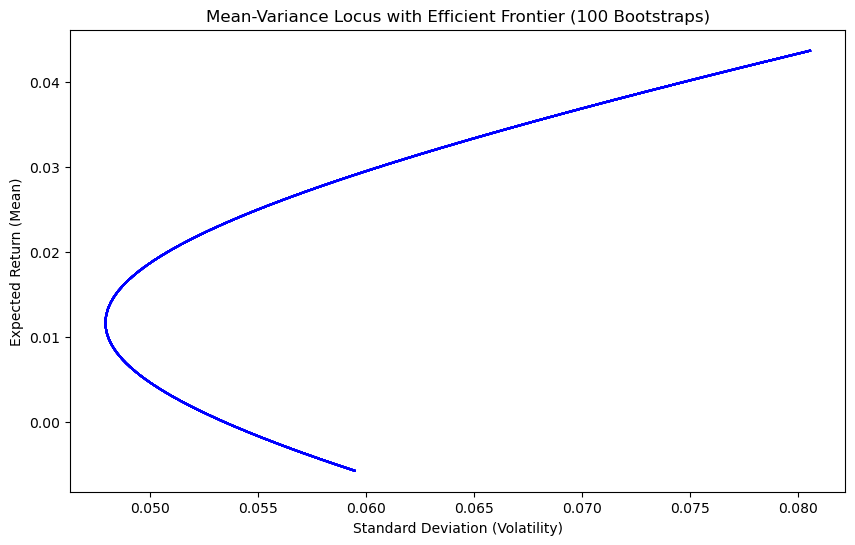

In [21]:
# Plotting
plt.figure(figsize=(10, 6))
for volatilities, returns in zip(all_volatilities, all_returns):
    plt.plot(volatilities, returns, color='blue', alpha=0.1)  # Alpha for transparency
# Add labels and legend
plt.title('Mean-Variance Locus with Efficient Frontier (100 Bootstraps)')
plt.xlabel('Standard Deviation (Volatility)')
plt.ylabel('Expected Return (Mean)')
#plt.grid(True)
plt.show()

In [ ]:
weights_df